### Utilisation OpenCV pour détourer la cellule

> Le but est de supprimer tout ce qui se trouve au dehors de la cellule pour essayer d'améliorer les modèles

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import os
import cv2
from skimage import data
from skimage.exposure import histogram
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage.segmentation import watershed

In [2]:
# Contrast de l'image
def contrast(img):
    clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
    l, a, b = cv2.split(lab)  # split on 3 different channels

    l2 = clahe.apply(l)  # apply CLAHE to the L-channel

    lab = cv2.merge((l2,a,b))  # merge channels
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 


In [19]:
# Masque de la cellule
def mask(filepath, val_min, val_max):
    img = cv2.imread(filepath, cv2.IMREAD_COLOR) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_contrast = contrast(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img_gray = cv2.GaussianBlur(img_gray,ksize = (3,3), sigmaX = 0)
    elevation_map = sobel(img_gray)
    markers = np.zeros_like(img_gray)
    markers[img_gray > val_min] = 2
    markers[img_gray > val_max ] = 1
    segmentation = watershed(elevation_map, markers)
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    labeled_coins, _ = ndi.label(segmentation)
    # Séparation si globules rouges collées
    center_w,center_h = img_gray.shape[0]//2, img_gray.shape[1]//2
    img_mask = (labeled_coins!=labeled_coins[center_w,center_h]).astype('uint8')
    kernel = np.ones((9,9),np.uint8) 
    erode = cv2.erode(img_mask, kernel, iterations = 1)
    # Récupère uniquement la zone centrale
    labeled, _ = ndi.label(erode)
    cell = (labeled==labeled[center_w,center_h]).astype('uint8')
    #Agrandit pour récupérer le bord de la cellule
    dilate   = cv2.dilate(cell, kernel, iterations = 1)
    return img, (dilate==0).astype('uint8')

In [20]:
# Mise au format masque avec contour 
def trimap(image):
    kernel = np.ones((9,9),np.uint8) 
    dilation  = cv2.dilate(image, kernel, iterations = 1)
    dilation  = np.where(dilation == 1, 2, dilation)
    erode   = cv2.erode(image, kernel, iterations = 1)
    erode   = cv2.erode(image, kernel, iterations = 1)
    remake    = np.where(erode == 1 , 1, dilation)
    return remake


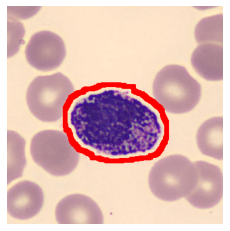

In [21]:
#img, img_mask = mask("Segmentation/images/N_BNE_725999.jpg",10,220)
img, img_mask = mask("../images_mendeley/PBC_dataset_normal_DIB//basophil/BA_26527.jpg",50,195)
img_marker = img.copy()
trimap_mask = trimap(img_mask)

img_marker[trimap_mask == 2] = [255,0,0]
plt.imshow(img_marker)
plt.axis('off')
plt.show()

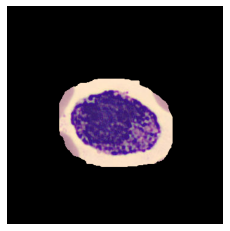

In [11]:
img, img_mask = mask("../images_mendeley/PBC_dataset_normal_DIB//basophil/BA_26527.jpg",50,195)
img_marker = img.copy()
trimap_mask = trimap(img_mask)

img_marker[trimap_mask == 1] = 0
plt.imshow(img_marker)
plt.axis('off')
plt.show()

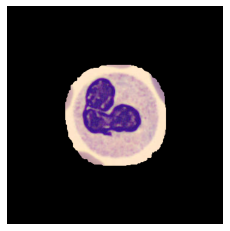

In [12]:
img, img_mask = mask("../images_mendeley/PBC_dataset_normal_DIB/neutrophil/BNE_725999.jpg",50,195)
img_marker = img.copy()
img_marker[img_mask == 1] = 0
plt.imshow(img_marker)
plt.axis('off')
plt.show()

In [13]:
### Base de 1400 images sélectionnées car pas de globules rouges agglomérées 
df = pd.read_csv('../files_segmentation.csv', index_col=0)
df.head()

,level_0,index,file_path,filename,class
0,0,0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil
1,1,4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil
2,2,6,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_10622.jpg,basophil
3,3,10,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_112418.jpg,basophil
4,4,12,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_114899.jpg,basophil


In [41]:
df['class'].value_counts()

eosinophil      522
neutrophil      440
basophil        402
erythroblast     33
lymphocyte        3
Name: class, dtype: int64

In [46]:
#!mkdir ..\images_segmentation\trimaps # Windows
!mkdir ../images_segmentation/verif

In [14]:
#Parcourt des images et stockage des images avec contour pour vérification du détourage
for index, file in df.iterrows():
    img, img_mask = mask(file['file_path'],50,195)
    img_marker = img.copy()
    trimap_mask = trimap(img_mask)
    img_marker[trimap_mask == 2] = [255,0,0]
    cv2.imwrite('../images_segmentation/verif/' + file['filename'].split('.')[0]+'.png', img_marker)

In [44]:
#!mkdir ..\images_segmentation\trimaps # Windows
!mkdir ../images_segmentation/trimaps

In [48]:
#Parcourt des images et stockage des masques dans répertoire trimaps
for index, file in df.iterrows():
    img, img_mask = mask(file['file_path'],50,195)
    cv2.imwrite('../images_segmentation/trimaps/' + file['filename'].split('.')[0]+'.png', trimap(img_mask) )